In [10]:
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix,
                             ConfusionMatrixDisplay, roc_curve, classification_report)
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import numpy as np
import pandas as pd


In [11]:
##Processa código de pré-processamento, transformação e limpeza de base

#%run pre_process.ipynb

#Leitura de importação de datasets
raiz = "C:\\Users\\marcus_sobral\\OneDrive - Sicredi\\Desktop\\Python\\Artigo\\"
base = pd.read_parquet(raiz + 'base_pre_process.parquet')

In [12]:
base.head()

,faixa_risco_concessao,vlr_financ,saldo_over_30,saldo_over_60,saldo_over_90,tempo_assoc,idade,renda,cred_a_vencer_360,comp_renda,severidade,comp_total,des_grupo_garantia
0,8.0,300000.00,0,0,0,6.0,68.0,661128.65,68104.500000,0.103012,0.0,351829.00,0.0
1,7.0,26000.00,0,0,0,6.0,68.0,661128.65,68104.500000,0.103012,0.0,351829.00,0.0
2,8.0,25829.00,0,0,0,6.0,68.0,661128.65,68104.500000,0.103012,0.0,351829.00,0.0
3,6.0,17900.00,0,0,0,6.0,69.0,6923.92,2463.500000,0.355796,0.0,17900.00,0.0
4,3.0,7117.92,0,0,0,8.0,74.0,6191.56,2707.166667,0.437235,0.0,7117.92,0.0


In [13]:
##Base clonada para inspeção de dados

base_graf = base.copy()

# Ajustando daods para representação visual
tipos_garantias = {-1: 'SEM GARANTIA', 
                   -1: 'SEGURO', 
                   1: 'AVALISTA',  
                   2:'PENHOR',
                   3: 'ALIENAÇÃO E CESSÃO'
                   }

base_graf['des_grupo_garantia'] = base_graf['des_grupo_garantia'].map(tipos_garantias)

faixas_risco= {
               0: '0_Default',
               1: '1_Altíssimo', 
               2: '2_Alto2', 
               3: '3_Alto1', 
               4: '4_Médio2', 
               5: '5_Médio1',
               6: '6_Baixo2', 
               7: '7_Baixo1', 
               8: '8_Baixíssimo'
               }

base_graf['faixa_risco_concessao'] = base_graf['faixa_risco_concessao'].map(faixas_risco)
base_graf.head()

,faixa_risco_concessao,vlr_financ,saldo_over_30,saldo_over_60,saldo_over_90,tempo_assoc,idade,renda,cred_a_vencer_360,comp_renda,severidade,comp_total,des_grupo_garantia
0,8_Baixíssimo,300000.00,0,0,0,6.0,68.0,661128.65,68104.500000,0.103012,0.0,351829.00,NaN
1,7_Baixo1,26000.00,0,0,0,6.0,68.0,661128.65,68104.500000,0.103012,0.0,351829.00,NaN
2,8_Baixíssimo,25829.00,0,0,0,6.0,68.0,661128.65,68104.500000,0.103012,0.0,351829.00,NaN
3,6_Baixo2,17900.00,0,0,0,6.0,69.0,6923.92,2463.500000,0.355796,0.0,17900.00,NaN
4,3_Alto1,7117.92,0,0,0,8.0,74.0,6191.56,2707.166667,0.437235,0.0,7117.92,NaN


In [14]:
#Dados de quantidade de operações por faixa de risco para gráficos
qtde_por_faixa = base_graf['faixa_risco_concessao'].value_counts()
qtde_por_faixa = pd.DataFrame(qtde_por_faixa)
qtde_por_faixa = qtde_por_faixa.reset_index()
qtde_por_faixa.columns = ['Faixa de Risco', 'Quantidade']
qtde_por_faixa = qtde_por_faixa.sort_values(by=['Faixa de Risco'])

print(f"Quantidade total de operações: {qtde_por_faixa['Quantidade'].sum()}")
qtde_por_faixa.head(9)

Quantidade total de operações: 9458


,Faixa de Risco,Quantidade
8,0_Default,178
7,1_Altíssimo,492
2,2_Alto2,1610
5,3_Alto1,817
0,4_Médio2,1714
4,5_Médio1,930
1,6_Baixo2,1667
3,7_Baixo1,1533
6,8_Baixíssimo,517


<function matplotlib.pyplot.show(close=None, block=None)>

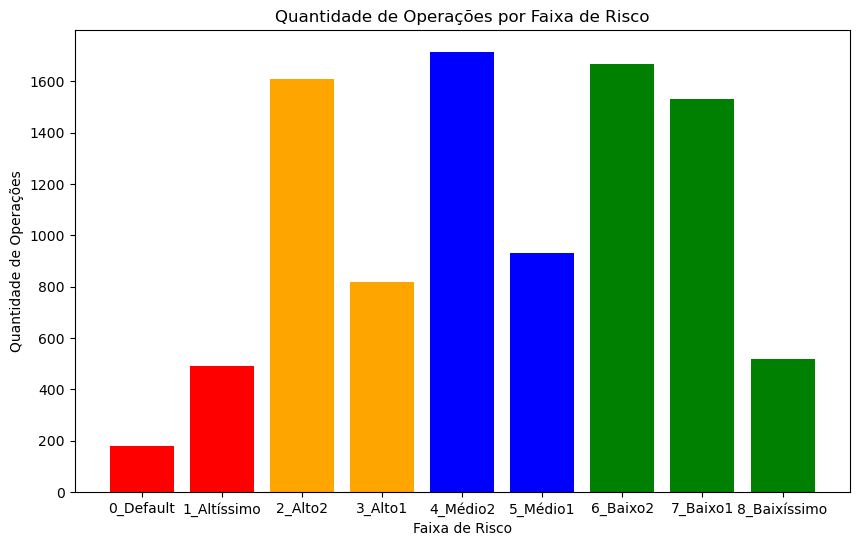

In [15]:
plt.figure(figsize=(10,6))
barras = plt.bar(qtde_por_faixa['Faixa de Risco'], qtde_por_faixa['Quantidade'], color = ['red', 'red', 'orange', 'orange', 'blue', 'blue', 'green', 'green', 'green'])
plt.xlabel('Faixa de Risco')
plt.ylabel('Quantidade de Operações')
plt.title('Quantidade de Operações por Faixa de Risco')
plt.show

In [16]:
#Dados de quantidade de operações totais e inadimplentes para gráficos
inad_por_faixa = base_graf.groupby(['faixa_risco_concessao'])['saldo_over_30'].agg(['sum', 'count'])
inad_por_faixa = inad_por_faixa.reset_index()
inad_por_faixa.columns = ['Faixa de Risco', 'Inadimplentes', 'Quantidade']
inad_por_faixa['Percentual Inadimplente'] = inad_por_faixa['Inadimplentes']/ inad_por_faixa['Quantidade']
inad_por_faixa

,Faixa de Risco,Inadimplentes,Quantidade,Percentual Inadimplente
0,0_Default,17,178,0.095506
1,1_Altíssimo,59,492,0.119919
2,2_Alto2,188,1610,0.116770
3,3_Alto1,59,817,0.072215
4,4_Médio2,106,1714,0.061844
5,5_Médio1,56,930,0.060215
6,6_Baixo2,89,1667,0.053389
7,7_Baixo1,41,1533,0.026745
8,8_Baixíssimo,2,517,0.003868


<function matplotlib.pyplot.show(close=None, block=None)>

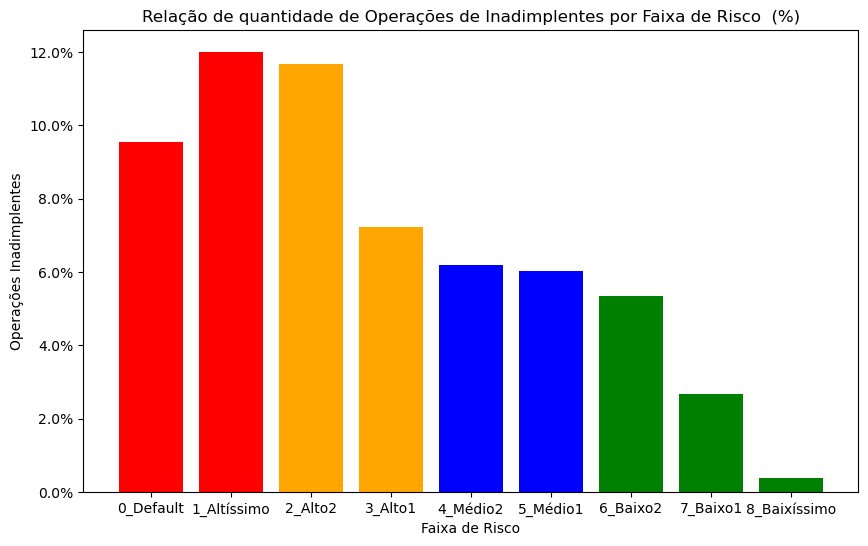

In [17]:
plt.figure(figsize=(10,6))
barras = plt.bar(inad_por_faixa['Faixa de Risco'], inad_por_faixa['Percentual Inadimplente'], color = ['red', 'red', 'orange', 'orange', 'blue', 'blue', 'green', 'green', 'green'])
plt.xlabel('Faixa de Risco')
plt.ylabel('Operações Inadimplentes')
plt.title('Relação de quantidade de Operações de Inadimplentes por Faixa de Risco  (%)')
plt.gca().yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))
plt.show

In [18]:
#Dados de saldos totais e inadimplentes para gráficos
valor_total = pd.DataFrame(base_graf.groupby(['faixa_risco_concessao'])['vlr_financ'].agg(['sum'])).reset_index()
valor_total.columns = ['Faixa de Risco', 'Saldo Total']

base_inad = base_graf[base_graf['saldo_over_30'] == 1]
valor_inad = pd.DataFrame(base_inad.groupby(['faixa_risco_concessao'])['vlr_financ'].agg('sum')).reset_index()
valor_inad.columns = ['Faixa de Risco', 'Saldo Inadimplente']

saldo_inad_faixa_risco = pd.merge(valor_total, valor_inad, how = 'outer', on = 'Faixa de Risco')
saldo_inad_faixa_risco['Percentual Saldo Inadimplente'] = saldo_inad_faixa_risco['Saldo Inadimplente']/ saldo_inad_faixa_risco['Saldo Total']
saldo_inad_faixa_risco.head()

,Faixa de Risco,Saldo Total,Saldo Inadimplente,Percentual Saldo Inadimplente
0,0_Default,2827779.41,212570.53,0.075172
1,1_Altíssimo,7650448.47,765741.38,0.100091
2,2_Alto2,26007910.44,2816530.66,0.108295
3,3_Alto1,10614513.76,635263.12,0.059849
4,4_Médio2,23291198.83,1449880.55,0.062250


<function matplotlib.pyplot.show(close=None, block=None)>

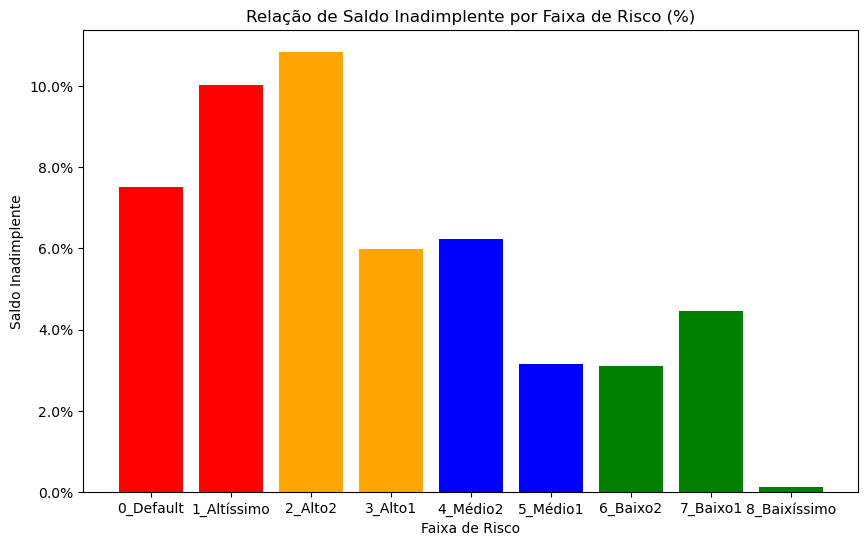

In [19]:
plt.figure(figsize=(10,6))
barras = plt.bar(saldo_inad_faixa_risco['Faixa de Risco'], saldo_inad_faixa_risco['Percentual Saldo Inadimplente'], color = ['red', 'red', 'orange', 'orange', 'blue', 'blue', 'green', 'green', 'green'])
plt.xlabel('Faixa de Risco')
plt.ylabel('Saldo Inadimplente')
plt.title('Relação de Saldo Inadimplente por Faixa de Risco (%)')
plt.gca().yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))
plt.show

In [20]:
base_reduzida = base[base['faixa_risco_concessao'] <= 4]
contagem = base_reduzida['saldo_over_30'].value_counts()
contagem_total = base_reduzida['saldo_over_30'].count()
print(f"Quantidade de Contratos: {len(base_reduzida)}")
print(f"Contratos adimplentes: {contagem[0]}")
print(f"Contratos inadimplentes: {contagem[1]}")
print(f"Contratos inadimplentes (%): {(contagem[1]/contagem_total) * 100:.3f}%")

Quantidade de Contratos: 4811
Contratos adimplentes: 4382
Contratos inadimplentes: 429
Contratos inadimplentes (%): 8.917%


In [21]:
base30d = base_reduzida.drop(['saldo_over_60', 'saldo_over_90'], axis = 1)
base60d = base_reduzida.drop(['saldo_over_30', 'saldo_over_90'], axis = 1)
base90d = base_reduzida.drop(['saldo_over_30', 'saldo_over_60'], axis = 1)

In [22]:
#Preparo de variáveis para utilização no modelo

# Separando features e classificações alvo
X = base30d.drop('saldo_over_30', axis = 1) #features
y = base30d['saldo_over_30'] #alvo

# Criação dos conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


# Criação do modelo XGBClassifier
model = XGBClassifier(objective='binary:logistic', use_label_encoder=False, eval_metric='logloss')

In [23]:
## Otimização dos parâmetros com o GridSearchCV

# Definição da grade de hiperparâmetros para otimização
param_grid = {
    'max_depth': [6, 7, 8],
    'learning_rate': [0.5, 1.0, 1.5],
    'n_estimators': [150, 200, 250],
    'subsample': [0.9, 1.0, 2],
    'colsample_bytree': [0.9, 1.0, 2]
}

# Configuração do GridSearchCV com foco na Curva ROC
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='roc_auc', cv=5, verbose=1, n_jobs=-1)

# Fit do modelo no GridSearchCV
grid_search.fit(X_train, y_train)

# Exibição dos melhores hiperparâmetros
print(f"Melhores hiperparâmetros: {grid_search.best_params_}")

# Treino do modelo com os melhores hiperparâmetros
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)

# Realização das previsões
predictions = best_model.predict(X_test)

# Cálculo das probabilidades das predições
proba_predictions = best_model.predict_proba(X_test)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


c:\Users\marcus_sobral\AppData\Local\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
675 fits failed out of a total of 1215.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
270 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\marcus_sobral\AppData\Local\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\marcus_sobral\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\marcus_sobral\AppData\Local\anaconda3\Lib\site-packages\xgboost\sklearn.py", line

Melhores hiperparâmetros: {'colsample_bytree': 0.9, 'learning_rate': 0.5, 'max_depth': 7, 'n_estimators': 150, 'subsample': 1.0}


c:\Users\marcus_sobral\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:24:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [24]:
# Avalianção das labels e predictions
print('Labels do modelo: ', np.unique(predictions, axis = 0))
print('Probabilidades do modelo: ', proba_predictions)

Labels do modelo:  [0 1]
Probabilidades do modelo:  [[9.9980825e-01 1.9175996e-04]
 [9.9915123e-01 8.4876019e-04]
 [9.9618191e-01 3.8181231e-03]
 ...
 [9.9996167e-01 3.8327635e-05]
 [9.9914813e-01 8.5188530e-04]
 [9.9997222e-01 2.7789258e-05]]


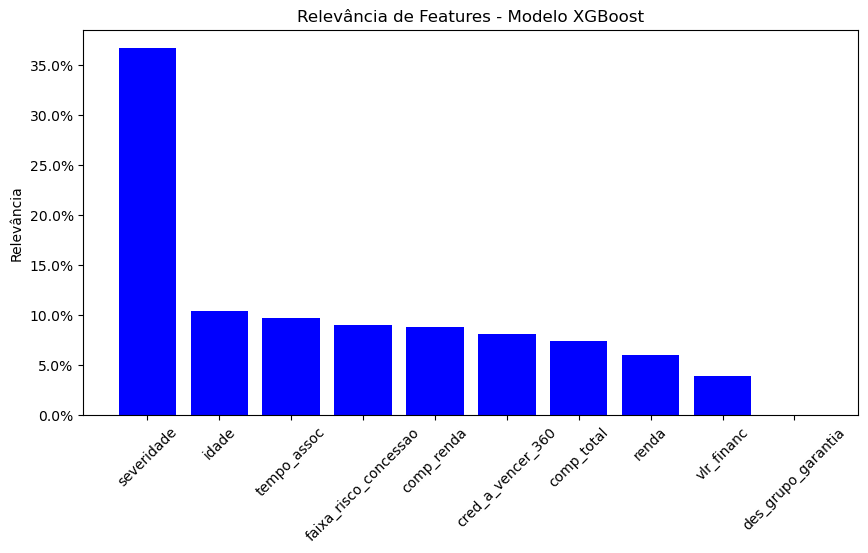

In [25]:
#Extração das características das features
probab_features = best_model.feature_importances_
feature_names = X.columns
features_importances = pd.DataFrame({'Feature': feature_names, 'Relevância': probab_features})

#Ranking de características
features_importances = features_importances.sort_values(by='Relevância', ascending=False)

#Plota visualização com os dados das características ordenadas
plt.figure(figsize=(10,5))
plt.bar(features_importances['Feature'], features_importances['Relevância'], color='blue')
#plt.xlabel('Features')
plt.xticks(rotation=45)
plt.ylabel('Relevância')
plt.title('Relevância de Features - Modelo XGBoost')
plt.gca().yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))
plt.show()


In [26]:
features_importances = features_importances.reset_index()
features_importances = features_importances.drop(['index'], axis = 1)
features_importances

,Feature,Relevância
0,severidade,0.367303
1,idade,0.104144
2,tempo_assoc,0.097059
3,faixa_risco_concessao,0.090050
4,comp_renda,0.087554
5,cred_a_vencer_360,0.081046
6,comp_total,0.074192
7,renda,0.059786
8,vlr_financ,0.038865
9,des_grupo_garantia,0.000000


In [27]:
# Avaliação do modelo
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)
roc_auc = roc_auc_score(y_test, predictions)

# Exibição das métricas
print(f"Acurácia: {accuracy:.2f}")
print(f"Precisão: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print(f"AUC-ROC: {roc_auc:.2f}")

Acurácia: 0.95
Precisão: 0.82
Recall: 0.52
F1-Score: 0.64
AUC-ROC: 0.76


In [28]:
#Dados da Classificação
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97      1092
           1       0.82      0.52      0.64       111

    accuracy                           0.95      1203
   macro avg       0.89      0.76      0.80      1203
weighted avg       0.94      0.95      0.94      1203



In [29]:
#Quantidade de dados
y_count = pd.DataFrame(y_test).value_counts()
pred_count = pd.DataFrame(predictions).value_counts()

print(f"Rotulos: {y_count}, Predict: {pred_count}")

Rotulos: saldo_over_30
0                1092
1                 111
dtype: int64, Predict: 0    1132
1      71
dtype: int64


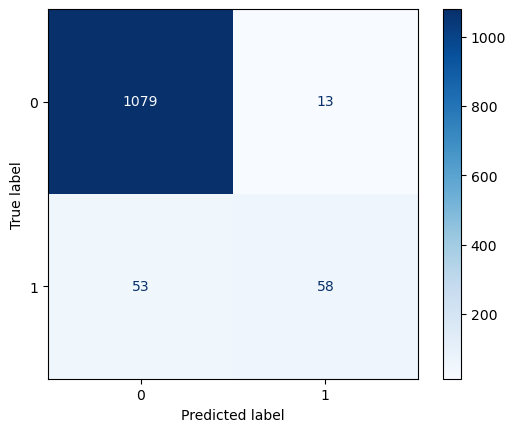

In [30]:
## Análise da Matriz de Confusão e avaliação de possível Overfitting/ Predições de falsos positivos
# Criação da matriz de confusão
cm = confusion_matrix(y_test, predictions)

# Exibição a matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot(cmap=plt.cm.Blues)
plt.show()

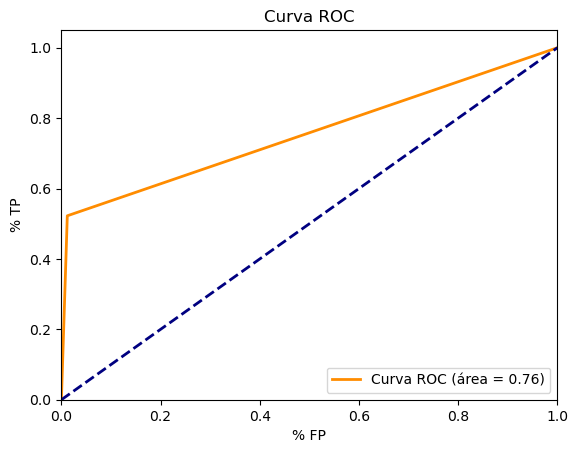

In [31]:
# Plotar a curva ROC
fpr, tpr, thresholds = roc_curve(y_test, predictions)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (área = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('% FP')
plt.ylabel('% TP')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()
